## Background

This is an exploration of a dataset concerning scores of patients over time from GAD-7 assessments.  There are five columns in the data -- the time of the measurement `date`, an ID number `patient_id`, the type of assessment submitted `type`, the date that the patient entered the system `patient_date_created`, and the assessment score `score`.  There are 53,698 entries in the data file.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

assessments = pd.read_csv("phq_all_final (1) (2) (2).csv")

## First Checks

The first things to check are if variable types are okay and if there is missing data.  The `date` and `patient_date_created` columns appear to have been stored as strings, so those need to be transformed first.

In [2]:
assessments.dtypes

date                    object
patient_id               int64
type                    object
patient_date_created    object
score                    int64
dtype: object

In [3]:
assessments["date"] = pd.to_datetime(assessments["date"])
assessments["patient_date_created"] = pd.to_datetime(assessments["patient_date_created"])

There seems to be no missing data, which is good.

In [4]:
assessments.isna().sum()

date                    0
patient_id              0
type                    0
patient_date_created    0
score                   0
dtype: int64

There don't appear to be any odd dates in `date` or `patient_date_created`, or scores outside the test's range of 0 to 21.

In [5]:
assessments["date"].min(), assessments["date"].max(), \
assessments["patient_date_created"].min(), assessments["patient_date_created"].max()

(Timestamp('2019-06-06 16:31:34.960999'),
 Timestamp('2020-07-31 20:11:33.663924'),
 Timestamp('2019-06-03 13:23:02.635680'),
 Timestamp('2020-07-31 17:58:21.004418'))

In [6]:
assessments["score"].quantile([0,0.5,1])

0.0     0.0
0.5     3.0
1.0    21.0
Name: score, dtype: float64

There's only one value in the `type` variable, which means that we don't have to remove data from different tests.

In [7]:
assessments["type"].value_counts()

gad7    53698
Name: type, dtype: int64

## Exploratory Plots

Note that a lot of this analysis is based on the assumption that these records are "complete", in the sense that the patient no longer needs to repeat the assessment.  The month-level counts of both `date` and `patient_date_created` aren't particularly uniform, which might suggest that the data isn't simply a list of all assessments in the given 14-month period.  I can't really say for certain without additional information on the data-generating process.

In [8]:
# quick look at distribution of assessment and "patient created" dates
time_periods = pd.DataFrame({"date_year":assessments["date"].dt.year,
                             "date_month":assessments["date"].dt.month,
                             "created_year":assessments["patient_date_created"].dt.year,
                             "created_month":assessments["patient_date_created"].dt.month})
date_counts = time_periods.groupby(["date_year", "date_month"]).size()
created_counts = time_periods.groupby(["created_year", "created_month"]).size()
pd.DataFrame([date_counts, created_counts])

date_year   2019                                      2020                    \
date_month    6     7     8     9     10    11    12    1     2     3     4    
0            177   471  1067  1950  2744  3234  3814  4953  5304  6158  7072   
1           1616  1686  5100  3739  4273  4870  5505  6152  7323  5844  3843   

date_year                     
date_month    5     6     7   
0           5797  5420  5537  
1           1508  1446   793

Given that `type` consists solely of a single value, we have four features that we could potentially analyze.  Looking at the structure and description of the columns, a few ideas come to mind.  For instance, how many assessments have been done by each patient?

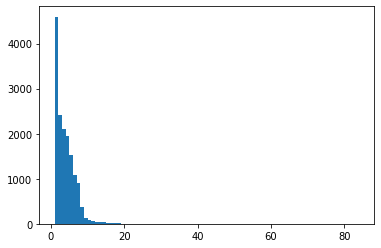

In [9]:
assessments_by_patient = assessments.groupby("patient_id")
assessment_counts = assessments_by_patient.size()
plt.hist(assessment_counts, bins=np.array(range(1,assessment_counts.max()+1)))
plt.show()

So the plurality of patients only have one assessment recorded -- upwards of 5000 out of roughly 15000 subjects.  Are these patients ones who scored well -- that is, ones who scored under the 10-point threshold for further clinical evaluation -- the first time?  

In [10]:
# note - bins for np.histogram() include the left side of the bin but not the right side
# except for the last one, so the first covers scores 0-9 and the second covers 10-21
first_day = assessments.sort_values("date").groupby("patient_id").aggregate(lambda x: x.head(1))
first_score_df = pd.DataFrame({"Count":assessment_counts, "FirstDayScore":first_day["score"]})
first_scores = first_score_df[first_score_df["Count"] == 1]["FirstDayScore"]
np.histogram(first_scores, bins=np.array([0,10,21]))

(array([3472, 1125]), array([ 0, 10, 21]))

In excess of 75% of the patients who have only one record scored at or below the recommended threshold for further evaluation.  And of all patients, over 80% have their final record as being under the 10-point threshold.

In [11]:
# histogram for scores on final assessments taken
last_day = assessments.sort_values("date").groupby("patient_id").aggregate(lambda x: x.tail(1))
np.histogram(last_day["score"], bins=np.array([0,10,21]))

(array([12644,  2858]), array([ 0, 10, 21]))

While I wouldn't expect the assessment to be sole indicator of an anxiety disorder, the fact that there are a lot of people whose last treatment ends with a score over that threshold is curious to me -- especially for the 25% of people who have only taken one assessment and scored at least 10 points.

This doesn't help answer questions about what happens over time, though.  For people who had more than one assessment, did their scores decrease between the first and second ones?

In [12]:
# group by patient, record the first and second assessment scores, and take the difference
assessment_by_patient = assessments.sort_values("date").groupby("patient_id")
score1 = []
score2 = []
for s, g in zip(assessment_counts, assessment_by_patient.groups.keys()):
    if s > 1:
        patient = assessment_by_patient.get_group(g)
        score1.append(patient.iloc[0,-1])
        score2.append(patient.iloc[1,-1])
score_change = np.array(score2)-np.array(score1)

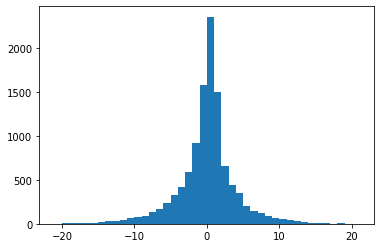

In [13]:
plt.hist(score_change, bins=range(-21,22))
plt.show()

In [18]:
np.histogram(score_change, bins=[-21,0,1,21])  # bins set to have bins that cover -21 to -1, 0, and 1 to 21

(array([4773, 2357, 3775]), array([-21,   0,   1,  21]))

In [19]:
score_change[score_change > 0].mean(), score_change[score_change < 0].mean()  # avg score change per case

(3.175894039735099, -3.47349675256652)

The scores don't necessarily decrease -- in fact, they either stay the same or actually increase more than half the time, although the average decrease is larger in magnitude than the average increase.  The fact that the distribution includes swings of both -21 and +21 is a little concerning, though.  Massive swings like that are infrequent but it would make progress harder to track.  

Looking at the patterns of scores from individual patients, there are a number that are a bit strange:

In [20]:
# print successive scores for each patient with 2+ assessments for random skimming
for s, g in zip(assessment_counts, assessment_by_patient.groups.keys()):
    if s > 1:
        patient = assessment_by_patient.get_group(g)
        print(patient["score"].tolist())

[1, 0, 0, 0, 1, 1]
[10, 11]
[16, 11, 11]
[4, 8, 7, 8]
[5, 6]
[2, 0, 6, 0, 0, 3, 2, 0]
[4, 2, 3, 4, 2]
[0, 0]
[1, 1, 1, 0, 4, 10]
[0, 1]
[0, 1]
[6, 0, 0, 0, 0, 0, 2]
[0, 1, 0, 0]
[1, 1]
[1, 0]
[1, 3, 0, 0, 1]
[2, 1, 3, 0, 5, 6, 2]
[7, 15, 8]
[2, 0, 3, 0]
[0, 1, 2, 1, 1, 0]
[2, 2, 0, 0]
[7, 6, 7, 6, 5, 3, 4]
[9, 5, 4, 5, 0, 2, 0, 0, 5, 6, 6, 4, 0, 0]
[13, 14]
[11, 8]
[0, 3, 1, 2, 5, 4]
[0, 1, 5, 1]
[1, 4]
[15, 1, 11, 17]
[9, 5, 5, 5]
[1, 0, 0, 1, 3, 3, 1, 0, 0]
[4, 18, 7, 18]
[11, 10, 10, 3, 4, 12, 11]
[7, 5]
[6, 10]
[2, 0]
[8, 0, 5, 8, 1]
[8, 7]
[7, 5, 9, 5, 7]
[6, 4, 2]
[10, 7, 18]
[7, 0, 0, 0]
[6, 10, 9, 6, 6, 9]
[0, 0]
[5, 2, 3, 2, 1, 2, 1]
[6, 2]
[1, 0, 0, 1, 0]
[0, 0, 1, 0, 1, 0, 0]
[1, 2, 0, 2, 2, 3, 3, 3]
[0, 0, 0]
[2, 0]
[1, 11, 10]
[9, 8, 9, 5]
[8, 3, 2, 9, 10]
[11, 7, 14, 10]
[6, 8, 4, 4, 4, 3, 4]
[0, 0, 0, 0, 2]
[6, 5, 4]
[3, 2]
[3, 0, 0, 0, 1]
[20, 19, 20, 20]
[0, 4, 2, 3, 4, 5, 8, 7, 7, 8, 4, 4, 0]
[11, 14]
[1, 0, 2, 0]
[16, 8, 7, 11, 9, 13, 13]
[5, 1, 6]
[5, 5, 4, 6, 9]
[0

[1, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0]
[3, 3]
[1, 0, 0]
[3, 0]
[0, 2, 1, 1, 3]
[7, 5, 7]
[3, 4, 1]
[0, 1, 0]
[9, 7]
[0, 2, 1, 4]
[17, 20]
[6, 4]
[0, 2, 3, 6, 5, 0]
[3, 1]
[4, 1, 0, 1, 0, 0, 1, 0, 0, 0]
[13, 2]
[1, 0, 0, 1, 0, 0, 1]
[5, 0, 1, 0, 0, 1, 0, 0]
[1, 0, 0, 1, 0, 0, 1, 1, 1, 0]
[21, 5]
[18, 18]
[2, 1, 1]
[0, 1, 0, 0, 0, 0, 0]
[3, 1, 3, 2, 13, 11]
[3, 1, 4, 1]
[1, 0, 2, 0, 0, 1, 0]
[9, 9]
[7, 2]
[1, 6, 3, 4]
[1, 0, 0]
[2, 0]
[7, 14, 9]
[16, 15, 11, 5, 6, 8, 11, 7, 7, 9, 16, 10, 10, 6, 7, 6, 12, 7]
[0, 1, 0, 8, 10]
[1, 0]
[1, 1]
[13, 19, 1]
[1, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 1, 0]
[0, 0]
[1, 1, 0]
[5, 9, 8, 0]
[12, 13]
[5, 6]
[19, 14, 10, 8, 19, 9, 12]
[4, 4, 6, 8, 8, 7, 8]
[1, 0]
[0, 2]
[12, 16, 9, 20]
[16, 6, 8]
[1, 0, 0]
[1, 1, 0]
[17, 21, 15, 20, 17]
[1, 1, 0]
[2, 1, 1]
[1, 0, 0, 0, 1]
[0, 1, 7]
[3, 7, 8, 5, 6, 5, 2]
[7, 8]
[2, 8]
[3, 10, 12, 0]
[8, 18]
[0, 1, 1, 0, 0]
[15, 6, 4, 5, 5]
[14, 19, 19, 10, 14]
[1, 1, 0]
[5, 7]
[8, 16, 9, 11, 6, 5, 8, 12]
[1, 2, 0, 1, 8, 3

[1, 0, 1, 1]
[17, 18, 11, 15, 16]
[20, 20]
[1, 0, 1]
[3, 0, 0]
[4, 7, 8, 0]
[0, 1]
[9, 18]
[1, 2, 1]
[3, 2]
[5, 15, 4, 5, 11, 8]
[0, 0]
[8, 3, 0, 4, 1, 0, 2]
[1, 4, 2]
[1, 0, 0, 1, 1, 0, 1, 1, 0, 0]
[11, 9, 0, 2, 1]
[0, 0]
[2, 0, 0, 0, 0, 1, 0, 0, 1, 0]
[5, 7, 9, 6]
[15, 16, 4, 2, 3]
[3, 1]
[2, 2, 1, 8, 0]
[3, 0, 0, 1, 6]
[1, 0, 0, 0, 0]
[1, 2, 1]
[9, 2, 0, 0]
[2, 1]
[8, 8, 10, 7, 7, 9, 5, 7, 7, 9]
[0, 1, 0, 0, 0, 1, 0, 1, 0]
[3, 3]
[10, 16, 17, 16, 19]
[14, 10, 13, 5]
[13, 2, 1, 4, 4, 7]
[17, 21, 16, 8, 3, 3]
[1, 0]
[3, 9]
[3, 0, 0]
[2, 2, 2, 4]
[1, 1, 4]
[8, 10, 8, 6, 7]
[2, 0, 1]
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0]
[3, 3, 2, 1, 2, 5, 1, 1, 0, 1, 3, 0, 0, 2]
[4, 2, 3, 0]
[5, 3, 5, 8, 9, 8, 5]
[2, 3, 0, 2, 3, 1, 2]
[21, 9]
[8, 15]
[0, 0, 0, 1, 2, 12, 11, 1, 3, 0]
[0, 0]
[5, 5, 5, 1, 6, 9, 15, 13, 14, 14, 13, 14, 9, 10, 8, 3, 5, 6, 8, 11]
[10, 13]
[18, 16, 16, 19, 14, 19, 19]
[4, 0, 0]
[3, 0, 2, 7]
[1, 4, 3]
[7, 5, 3, 4]
[1, 1, 1, 0]
[1, 0]
[7, 3, 1]
[1, 1, 1, 0, 1]
[16, 15, 17, 9]
[8, 

[1, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 1]
[4, 2, 1, 1, 1, 1]
[3, 0]
[10, 8]
[1, 1, 1, 1]
[14, 17, 21, 21, 14, 18, 18]
[18, 21, 19]
[0, 1, 0, 1, 1, 0]
[6, 6, 3, 8, 3, 5, 1]
[0, 0, 0, 4]
[0, 0, 0, 0]
[0, 1, 0, 0, 0, 3, 1]
[7, 4, 0, 1, 0, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0]
[5, 6, 3, 2, 3, 3, 1, 2, 4, 1, 6, 4, 3, 7]
[5, 2, 13]
[1, 0]
[11, 13, 15]
[13, 8, 6, 6]
[18, 19, 19, 21, 19, 17, 20]
[10, 8, 11, 5, 0, 1, 1]
[18, 15, 15, 16, 18, 15]
[9, 9, 0]
[0, 1]
[5, 0, 1, 0, 1]
[7, 1]
[3, 7, 1, 2, 5, 6]
[11, 5, 4, 1, 1, 15]
[1, 0, 0, 1]
[0, 1, 1, 7]
[5, 1, 5, 4]
[15, 17]
[2, 0, 0]
[0, 0, 1, 1, 1, 1]
[12, 4]
[20, 20, 21]
[7, 2, 6, 3, 4]
[6, 9, 3]
[16, 10, 15, 12, 13, 12]
[0, 0, 0]
[8, 13, 9, 7, 7, 7]
[10, 10]
[10, 14, 11, 17]
[0, 0, 0, 0, 1]
[5, 19]
[5, 9, 3, 7, 5]
[9, 10, 9, 10]
[1, 1, 1, 0]
[3, 1]
[9, 10]
[0, 0, 0]
[5, 6, 1]
[20, 16, 14, 19, 15]
[7, 3, 7, 3]
[8, 21, 10, 17]
[5, 2, 0, 0]
[12, 0]
[0, 0, 0, 0]
[14, 14, 10, 7]
[0, 1]
[3, 0]
[5, 6]
[5, 3, 4, 7, 8, 1]
[10, 9, 3, 4, 0]
[1, 6]
[3, 4, 12

[0, 5, 0, 0]
[1, 1, 4]
[7, 3, 0, 1]
[14, 10, 16, 17, 8]
[4, 2, 6, 1]
[16, 13]
[1, 1, 3, 0, 1]
[2, 4]
[4, 5]
[8, 8, 3, 1, 8, 1, 1]
[5, 6, 6, 3, 3, 6, 2]
[0, 8, 3, 0, 0, 1, 0, 0]
[0, 1, 1]
[0, 1]
[1, 3, 2]
[10, 5, 2, 2, 3, 3]
[0, 0]
[2, 1, 0, 0, 0, 0, 0]
[1, 0, 3, 2]
[0, 8, 4]
[7, 2, 6]
[2, 4]
[5, 9]
[1, 0]
[14, 12]
[8, 0]
[4, 0, 3, 3, 2, 1, 0, 0, 1]
[9, 4, 8, 8, 6, 7, 5, 5, 7]
[3, 5]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 15, 0, 1]
[5, 0, 9, 6, 3]
[11, 8, 1, 14, 7, 4]
[7, 3]
[20, 20, 20]
[10, 4, 2, 1, 1, 1, 0]
[0, 0, 1, 0, 1, 0]
[10, 20, 9, 2, 20]
[0, 0, 1, 4, 0, 0]
[11, 12, 17]
[0, 0, 0]
[1, 1, 1]
[0, 7]
[18, 16, 1, 9, 18, 1, 1, 1]
[14, 8, 6, 7]
[12, 4, 2]
[13, 12, 11, 14, 14, 14, 7]
[4, 4, 3, 2, 2, 1, 0, 3, 3, 1, 0, 0, 1, 2]
[6, 10]
[7, 11, 17, 6]
[11, 9, 12, 14]
[0, 0, 1]
[0, 1, 0, 1]
[2, 3]
[6, 6, 4]
[5, 0]
[12, 9, 2, 7]
[1, 11]
[4, 0, 1, 0, 1]
[7, 3, 2]
[3, 2, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1]
[2, 12]
[10, 5, 11, 10, 11, 9]
[0, 0]
[0, 1, 0, 0]
[0, 1, 0]
[2, 1, 1, 1, 0, 2]
[11, 

[11, 10]
[14, 9, 10, 10]
[5, 3, 7, 10, 7, 4]
[5, 6, 6, 3, 5, 5]
[11, 13, 12, 13, 12, 14, 13, 11, 7, 0]
[17, 13]
[11, 5, 6]
[1, 0, 1, 0]
[8, 6]
[1, 12, 6]
[4, 5, 0, 0, 1, 0]
[0, 3, 8]
[4, 2]
[4, 3, 2, 2, 1, 3, 2, 1]
[13, 21, 11, 14, 18, 9]
[0, 1]
[5, 2]
[0, 0, 1]
[0, 1, 0]
[6, 1, 0, 3]
[0, 0, 1, 3, 3]
[2, 0, 0, 0]
[1, 0, 0, 2, 0]
[3, 1]
[0, 4, 1]
[2, 1, 1, 2, 3, 2, 2]
[0, 1, 1, 3, 3]
[0, 2, 1, 7]
[6, 6, 7, 6, 7, 3, 6, 7, 5, 5]
[10, 17, 15, 18, 21, 18, 18]
[3, 3]
[8, 2, 3, 3, 2]
[1, 3, 0, 0, 0]
[2, 6, 1, 5]
[0, 11]
[5, 5, 4, 3, 4]
[0, 0, 1, 1]
[7, 6, 5, 5, 7]
[1, 0, 1]
[9, 7, 7, 11]
[0, 0]
[6, 7]
[6, 3, 7, 2, 1]
[5, 4, 5, 3]
[9, 4, 3, 4, 3, 4, 0, 3, 3]
[2, 8, 6, 7, 3, 4]
[0, 0, 1]
[1, 1]
[11, 5, 3, 6, 3, 6, 5, 1, 2, 6, 3, 3, 3, 2, 3, 2, 1, 2, 2, 2, 4, 4, 3, 8, 5, 6, 7, 7]
[1, 0, 4, 3]
[0, 1, 1]
[4, 1]
[2, 0, 1, 0]
[4, 2, 2, 0, 0, 1, 1, 1]
[0, 0]
[11, 8]
[7, 1, 4, 4]
[9, 6, 5]
[0, 0, 1]
[3, 3]
[1, 0, 0, 0]
[0, 2]
[0, 0, 0]
[2, 1, 1, 0]
[0, 5, 3, 1, 2, 0, 0]
[5, 9, 0, 0]
[6, 4, 4, 11, 3, 6

[0, 1, 8, 0]
[4, 4, 5, 6, 4, 5, 4, 3]
[13, 12, 5, 4]
[3, 3, 0, 1]
[5, 3, 2]
[8, 5, 6, 6, 3]
[1, 0, 0]
[7, 12]
[9, 10, 11, 18, 16, 7, 6, 14, 12]
[1, 0, 0, 1]
[1, 0, 1, 0]
[3, 5, 5]
[6, 1, 11, 1, 1]
[2, 1, 1, 2]
[6, 9, 6, 6]
[0, 1, 1, 0, 0, 0, 0, 0]
[4, 2, 2, 3, 3, 3]
[1, 1]
[5, 4, 2, 5, 4, 4, 3]
[0, 4, 0, 19]
[0, 0, 2, 3, 2]
[19, 17, 18, 20, 15]
[1, 3]
[1, 0, 3]
[2, 0, 3]
[3, 6, 3, 6, 5]
[6, 5]
[7, 2, 3]
[2, 3, 0, 1, 0]
[6, 4, 4]
[2, 6, 6, 7, 7, 8, 1, 1]
[9, 8, 13, 15, 3]
[11, 8, 10, 7, 5, 7]
[4, 10, 5, 4]
[17, 14, 10, 17]
[0, 0, 1, 1]
[0, 0, 1]
[7, 3, 2, 0, 1, 0]
[5, 3, 2, 1, 3, 3, 3, 5]
[15, 13, 11, 8]
[6, 5, 5, 11]
[5, 6, 3]
[12, 4, 4]
[14, 1]
[1, 2]
[3, 3, 0, 1, 2, 1]
[0, 0, 0]
[10, 7, 5, 1]
[18, 11, 15, 12]
[1, 1, 1]
[0, 11]
[4, 0]
[3, 0]
[2, 2, 2, 1, 3, 0]
[0, 0, 0, 3, 1]
[0, 1, 0, 0, 1, 0, 4]
[4, 5, 3]
[18, 17]
[0, 0]
[13, 11, 10]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 6, 0, 0, 2]
[2, 2, 0, 2, 0, 3, 2]
[5, 11, 1, 3, 6, 10, 8, 9]
[0, 0, 0, 0, 0]
[1, 1, 1, 2, 0]
[1, 9, 7, 5, 5, 1, 0

[1, 1]
[1, 0, 0, 0, 0]
[17, 10, 10, 4, 3, 5]
[0, 0, 0, 0]
[7, 4, 5, 4, 4, 2, 3, 3]
[1, 0, 0]
[13, 1, 0, 0, 1, 0, 0]
[0, 1]
[12, 4, 0]
[11, 11, 11]
[2, 0, 0, 0]
[0, 0, 0, 4, 2]
[4, 7]
[5, 1]
[3, 4]
[9, 4, 7, 4, 5]
[3, 0, 0, 1, 13, 5, 0]
[5, 12]
[4, 0, 0, 1]
[3, 7, 4]
[21, 21, 12, 9, 6, 6, 8, 8, 8, 7, 6, 10, 0, 0, 1]
[0, 0, 1]
[3, 0, 1, 0, 0]
[11, 2, 2, 5, 1]
[3, 4, 0, 0, 1]
[1, 0, 0]
[18, 12, 8, 21]
[2, 1]
[3, 4, 6, 1, 3, 1, 1, 1]
[1, 1, 2]
[9, 6, 2, 3]
[0, 4, 2, 1, 1, 3]
[0, 0, 1, 0, 0]
[13, 5, 5]
[0, 2, 3, 0, 11, 0, 0, 0, 1, 1, 0]
[0, 1, 0, 1, 1]
[0, 1]
[0, 2, 4]
[3, 2, 1]
[3, 1, 15, 0, 0, 1]
[2, 0, 1]
[4, 1, 0]
[3, 2, 4, 3]
[2, 6, 8]
[14, 5, 3, 5, 8, 6, 6]
[9, 3, 1, 0, 0, 0, 0]
[3, 0, 0, 0, 1, 0]
[1, 0, 0, 1]
[19, 19, 20, 21, 19]
[2, 1, 1, 2, 0, 1]
[6, 10, 10, 7, 13, 11, 15]
[11, 10]
[9, 14, 1, 17]
[5, 17, 6, 4, 7, 15]
[1, 4]
[5, 3]
[0, 0, 0]
[5, 8, 7]
[15, 7]
[0, 3, 1]
[2, 1, 0]
[3, 0, 4, 0]
[6, 3, 1, 3, 9]
[9, 8, 8, 16]
[0, 0]
[7, 0, 4, 6, 2]
[13, 13, 2, 10, 3, 0, 5]
[4, 3, 0, 0, 0

[1, 1, 0]
[2, 3]
[12, 2, 7, 13]
[7, 8, 6, 13, 8, 1]
[1, 2, 7, 0, 7]
[6, 10, 3]
[3, 1]
[1, 1]
[3, 0, 3]
[11, 12, 7, 20]
[6, 6, 14, 3, 10]
[10, 20, 15, 8, 6]
[0, 0, 2, 1, 0, 3]
[1, 0, 1, 0]
[4, 3]
[5, 4, 2, 1]
[0, 1, 1, 1, 1]
[0, 1, 1, 0]
[21, 21, 20, 17]
[2, 3, 3, 0, 5]
[11, 7, 10]
[5, 18, 5, 11]
[12, 13, 11]
[0, 0, 0, 1, 1]
[1, 2, 0, 2]
[5, 4, 2]
[0, 0, 2]
[5, 7, 4]
[0, 3]
[12, 13]
[2, 2, 6, 2, 4, 1, 1, 4]
[12, 18, 15, 8, 9, 11, 15, 18, 19]
[6, 2, 0]
[1, 1]
[1, 0]
[8, 6, 3, 0, 3]
[9, 9, 9]
[5, 5, 10, 9, 11, 15]
[0, 0]
[4, 3, 0]
[4, 5, 5, 5]
[1, 2]
[10, 11, 8]
[2, 0, 0]
[3, 9, 5, 3, 11, 14, 11]
[4, 9, 8, 7]
[3, 7]
[0, 1, 1]
[0, 0, 1]
[1, 0, 0, 0, 2, 0, 0]
[4, 2, 1, 0, 0]
[9, 7]
[4, 0, 0, 1, 1]
[6, 4]
[16, 19, 17]
[1, 0, 3, 0, 3, 1, 3, 5, 3]
[11, 6, 5, 11, 6]
[2, 4]
[0, 0, 0]
[3, 2, 2, 0]
[8, 8, 5, 3]
[0, 1, 0]
[7, 6, 1, 5, 5, 7]
[2, 5, 6, 4, 1]
[15, 18, 9]
[15, 14]
[1, 0]
[4, 8, 9, 4]
[10, 17, 14, 16, 16]
[0, 0, 0, 0, 0, 0, 0]
[12, 14, 9, 13]
[4, 1, 1, 2]
[0, 4]
[0, 1, 7, 7]
[15, 13, 10

[0, 0, 0, 1, 0, 0, 0, 2]
[1, 4, 4, 0, 2]
[3, 5, 10]
[0, 0, 0, 0, 0]
[9, 10, 4, 2, 7]
[15, 18, 14, 13, 12, 9, 6]
[19, 19, 11, 6]
[0, 0]
[1, 5]
[14, 11, 9, 14, 7, 8, 8, 9]
[0, 1, 0]
[6, 6, 5, 4, 5, 6]
[7, 10]
[1, 2, 4, 2, 1]
[13, 0, 0]
[10, 8, 4, 3]
[5, 0, 0]
[8, 6]
[3, 4, 2, 2, 1, 1, 1, 3]
[3, 15]
[0, 0, 0, 0]
[19, 10, 12]
[11, 11, 15, 6]
[0, 0, 0, 0, 0, 1]
[13, 0]
[3, 4, 0, 5, 6]
[0, 0, 0, 2, 1]
[19, 19, 16, 17, 19, 18]
[1, 1, 2]
[7, 4]
[0, 1, 0, 1]
[4, 0, 1]
[20, 18]
[0, 0, 1]
[0, 0, 1, 0]
[1, 0, 2]
[0, 0, 2, 0, 1]
[0, 0]
[9, 6, 1, 1]
[1, 0]
[0, 2]
[0, 0, 0]
[6, 2, 7, 6, 7, 7, 5, 4, 4, 11, 8, 4, 8, 8, 5]
[3, 0, 7, 2, 3, 10, 10]
[10, 1, 2, 3, 2, 0]
[3, 3, 2, 2, 6]
[8, 4, 5, 2]
[18, 14, 14, 17, 15, 15, 16, 16, 16, 15, 16, 19, 18, 16, 15, 18, 18, 17, 16, 17, 17, 17, 15, 18, 17, 17, 18, 16, 17, 15, 16, 15]
[0, 0]
[7, 11, 0]
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 1]
[14, 1, 5, 11]
[5, 4, 4, 6, 2]
[6, 1, 5]
[0, 1, 1]
[1, 3, 2]
[1, 3, 0, 0, 0, 3]
[14, 10, 2]
[7, 16, 13]
[0, 0, 0]
[9, 9, 8, 10]
[1,

[6, 4]
[0, 0, 1, 0]
[18, 17]
[12, 0, 0, 4, 0, 19]
[7, 9, 14]
[10, 11, 1]
[1, 0, 1]
[21, 3, 2, 3, 7, 11]
[0, 0]
[1, 0, 1, 0]
[15, 5, 1, 4, 6, 3, 9]
[5, 5]
[0, 0, 1, 0, 1]
[6, 0, 3, 3, 3, 1, 2]
[0, 1, 6]
[0, 5, 6, 3, 2]
[1, 0]
[6, 8]
[4, 5, 3, 4, 6]
[8, 19, 17, 18, 19]
[0, 0, 0]
[5, 2]
[0, 1]
[2, 0]
[9, 1, 5, 7, 6]
[7, 7]
[0, 1, 3, 0]
[1, 0]
[4, 6, 6, 5]
[3, 2, 9, 5]
[2, 0, 0]
[1, 1, 4]
[8, 10, 10, 10, 11, 11, 6, 7, 7, 6, 11, 7, 7, 5]
[7, 6, 1, 2]
[5, 6]
[11, 14, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1]
[2, 3, 0, 5, 4, 2, 5, 2, 3, 1, 2]
[1, 0, 4, 0]
[7, 2]
[10, 8, 10]
[21, 10]
[0, 0]
[3, 4, 13, 5]
[17, 6]
[0, 0, 6, 2]
[3, 5, 0, 0, 0, 2, 4, 1, 2, 2, 0]
[8, 4, 5, 3, 3, 5]
[9, 12, 9, 4, 8, 1]
[0, 1]
[0, 1, 1, 0, 0, 1, 0]
[0, 11, 3, 1, 1]
[3, 3, 1, 0, 1]
[1, 0, 2]
[0, 2, 0, 1]
[0, 1, 3, 0]
[1, 9, 7, 2]
[3, 4, 12, 6]
[4, 1, 5, 5, 3, 2, 0]
[10, 5, 0, 0, 0]
[1, 11, 5, 5, 5, 10, 9]
[2, 2, 1]
[20, 18]
[5, 5, 3, 3, 10, 10, 9, 10, 7, 7]
[1, 0, 0]
[4, 0, 3]
[21, 21, 14]
[6, 15, 1, 0]
[0, 3]
[

[0, 1, 1]
[0, 6, 0]
[7, 9, 7, 6, 9, 14, 13, 6]
[1, 1, 0]
[7, 7, 6]
[1, 1, 1, 2, 0, 2, 0]
[0, 0, 0]
[1, 1, 0, 0, 0, 0]
[2, 1, 0, 1, 2]
[12, 7, 12, 5, 12, 11]
[2, 3, 1, 1, 0]
[0, 3, 2, 0, 18]
[1, 0, 1, 0]
[2, 0, 3, 0, 1, 0, 1, 0]
[6, 5]
[5, 4, 1, 1, 1]
[0, 2, 0]
[4, 0, 0, 2]
[0, 0]
[1, 3, 0, 2, 0]
[1, 0, 1, 0, 1, 0]
[12, 9, 12, 18, 18]
[18, 17, 21, 13]
[3, 2]
[8, 7, 10]
[0, 0, 1]
[3, 6]
[4, 1, 4]
[0, 0, 0, 1]
[2, 0, 0]
[16, 7]
[14, 10, 5]
[7, 9, 7, 11, 9, 20, 8]
[14, 6, 10, 5, 6, 8, 14, 14]
[1, 1]
[3, 4, 2, 4, 4]
[4, 4, 2, 6, 19]
[21, 5, 8, 9, 4, 12]
[0, 0, 1, 0]
[10, 15, 6, 7, 14]
[11, 20, 21, 12]
[17, 16, 6]
[6, 4, 6, 6, 7, 7, 10]
[0, 0]
[20, 19, 15, 16]
[0, 0, 0]
[6, 6, 10, 4, 6, 4, 2, 1]
[10, 9, 10]
[1, 1, 0]
[0, 0]
[0, 0, 1, 0, 0, 0, 0]
[1, 0, 1]
[2, 5]
[1, 1, 2, 2]
[1, 0, 0]
[3, 4, 1, 1]
[5, 0, 15, 6]
[0, 0, 0, 0]
[10, 5]
[3, 0, 1, 0]
[8, 19, 20, 21]
[3, 7, 11, 3]
[2, 4, 5]
[7, 0, 5]
[5, 7, 2, 3, 0]
[2, 2, 7]
[0, 0, 1]
[3, 0, 0, 1, 0, 2, 2]
[0, 0, 1, 0, 0, 0]
[1, 0, 0, 1]
[20, 18, 

[3, 4]
[3, 0, 0, 1, 1]
[15, 11, 7, 9]
[2, 0, 3, 1]
[1, 1, 1, 1, 0, 0]
[4, 5, 4]
[3, 4]
[3, 1]
[2, 6, 2, 2, 1, 1, 0]
[1, 3, 3, 1, 0, 1, 0, 0, 2, 1, 2]
[4, 6, 6]
[8, 11]
[1, 0, 0, 1, 5]
[2, 1, 0, 2, 2]
[0, 1, 0, 0, 0, 0, 0, 2, 0]
[1, 0]
[3, 6, 5, 2, 2, 6, 1, 0, 4, 1]
[4, 6, 7, 7, 7]
[2, 0, 1, 0]
[19, 20]
[8, 8, 12]
[0, 0, 0, 0]
[0, 1, 3, 0, 1]
[1, 4, 1, 2]
[14, 13, 13, 11, 20, 21, 21, 17, 14, 15, 18, 19]
[6, 6]
[4, 4, 6]
[3, 7, 3, 0, 0, 0, 1, 0, 1, 0]
[10, 5, 5, 7]
[0, 0, 0]
[2, 6, 4, 8, 17, 20, 3]
[1, 0]
[0, 1]
[9, 5, 2, 0]
[17, 15]
[20, 18, 19, 17, 21, 14, 16, 18, 18, 20, 10, 10, 10, 19, 11, 14, 20, 17, 19]
[4, 7, 6, 11, 5, 4, 7]
[3, 2, 2, 2, 2, 3, 3]
[5, 9, 5]
[0, 0]
[0, 5, 1, 0]
[1, 0]
[0, 0, 0, 0]
[4, 2, 7, 6, 1]
[2, 3, 1, 5]
[10, 9, 8, 7]
[1, 4, 5, 5, 6]
[3, 2, 1, 2]
[2, 5, 6]
[17, 3, 1, 15, 9]
[3, 0]
[11, 10, 12]
[1, 0, 0, 0, 1, 0, 0, 0]
[7, 5, 1]
[1, 3]
[4, 3, 0, 9, 8, 2, 4]
[5, 5, 3, 4, 4, 1]
[6, 12]
[8, 8, 11, 5]
[1, 2, 0, 0, 0, 1, 1, 1, 0]
[12, 18]
[4, 3]
[12, 10, 7, 8, 8, 6, 

[10, 7, 8, 5, 11, 3, 4]
[5, 5, 2, 1]
[5, 3, 6]
[11, 3, 5, 0]
[4, 0, 5]
[3, 8]
[0, 0]
[0, 6, 4, 3]
[1, 0, 0, 0]
[13, 6, 6, 8]
[1, 0, 0, 1]
[2, 1, 1, 1, 2, 4]
[0, 0, 0, 0]
[8, 12]
[0, 1, 0]
[1, 0, 1]
[0, 9, 1, 0, 0]
[12, 13, 14]
[19, 15, 14, 13, 21, 15, 20]
[0, 0, 0, 1]
[7, 4, 0, 2]
[10, 12, 4, 7, 3]
[1, 3, 0, 3, 1]
[0, 1, 0]
[1, 1]
[2, 1, 4]
[4, 3, 7, 1, 2, 3, 3]
[10, 13, 7, 0]
[0, 4, 2, 6]
[1, 0, 0, 1, 1]
[3, 0, 0]
[5, 5, 3, 2]
[0, 0, 0, 1]
[1, 2]
[1, 0, 1, 0, 1, 0]
[14, 5, 6, 8, 4]
[5, 7, 7, 14, 12, 7, 7, 8, 5, 7, 7]
[0, 1, 0, 0, 0]
[11, 8, 9]
[0, 1, 0, 0, 1, 1]
[5, 3, 5, 0]
[4, 0, 1, 0, 1, 3]
[15, 18, 19]
[4, 6]
[0, 1, 0, 1, 0, 0, 2]
[0, 0, 0, 0, 0, 0]
[13, 16, 15, 12, 11, 11, 10]
[1, 3]
[2, 5, 1, 0]
[2, 2, 3]
[2, 0, 1, 1, 0]
[9, 16]
[2, 8, 4, 4, 6, 2]
[17, 12, 7, 12, 7]
[3, 4]
[0, 1, 0, 1, 1, 1, 0]
[1, 1, 3, 1, 0]
[0, 0]
[9, 6, 7, 8, 17]
[3, 3, 3, 4]
[4, 4, 7, 5, 5, 5, 2]
[2, 0, 1]
[8, 5]
[8, 6, 3]
[10, 8, 21]
[4, 5, 7]
[1, 2, 0, 2, 3]
[3, 13, 5, 6]
[0, 1, 1, 0]
[6, 5, 0, 1, 4]
[10,

[19, 20, 21, 17]
[16, 17, 18, 17, 8, 4, 8]
[13, 8, 7, 12, 7, 13, 9]
[1, 0]
[7, 4, 1, 0, 0, 3, 0, 1]
[8, 5, 6, 6, 10]
[0, 0, 1, 0]
[7, 9, 9, 6, 9, 11, 10, 7, 6, 6, 7, 8, 10]
[0, 2, 1]
[1, 1, 0, 0]
[1, 0, 0, 2]
[5, 2, 0, 1, 0, 1]
[11, 1, 5, 3, 0, 4]
[12, 6, 12, 6]
[1, 1, 1, 0]
[1, 1, 1]
[0, 2, 1, 0]
[0, 0, 1, 0, 0]
[2, 2]
[4, 3, 2, 1]
[13, 11]
[17, 9, 11, 10, 7, 6]
[21, 20, 21, 21]
[4, 2, 2, 3, 5]
[0, 1, 5, 1, 1, 0, 0]
[0, 3, 6, 0, 3]
[1, 1, 1, 1, 0, 1, 2]
[1, 1, 1, 1]
[3, 4, 2, 4, 2, 0, 0]
[15, 13, 15]
[0, 1]
[0, 0, 0, 0]
[0, 0, 0]
[1, 3]
[4, 7]
[8, 1, 0, 5]
[2, 4]
[10, 4, 7, 10, 16]
[2, 1, 0]
[0, 1, 0, 1, 5, 5, 7]
[1, 0, 0]
[8, 8, 5, 4, 5, 5, 6, 6, 5, 6, 6]
[9, 10]
[10, 3, 3, 5, 4, 6, 3]
[0, 0, 1, 1, 2, 1, 0, 2, 9, 3]
[20, 21, 21, 16, 1, 1, 11]
[6, 4, 3, 0]
[8, 0, 5, 6, 6]
[3, 2, 1]
[14, 15]
[17, 2, 15]
[9, 8, 7, 7, 7, 6, 11, 12, 13, 13, 16, 12, 15]
[4, 6, 6, 7, 2, 7, 6]
[1, 3, 2, 4]
[8, 3, 6, 0, 2, 3]
[4, 13]
[10, 10, 15]
[3, 2, 2, 2, 1]
[1, 0, 1, 0]
[2, 2, 3, 1, 0, 0, 1, 0]
[4, 0, 0]

There are many subjects who consistently report very low scores over several assessments or more, which would seem to raise the question of what they're doing there exactly.  We can try to look at the scores over time for all patients, though this produces a somewhat chaotic plot:

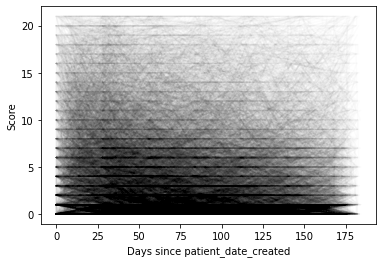

In [21]:
assessments_diff = assessments.copy()
assessments_diff["TimeDiff"] = assessments_diff["date"] - assessments_diff["patient_date_created"]
assessments_diff["TimeDiff"] = assessments_diff["TimeDiff"].dt.total_seconds() / 86400
assessment_diff_by_patient = assessments_diff.sort_values("date").groupby("patient_id")

for s, g in zip(assessment_counts, assessment_diff_by_patient.groups.keys()):
    if s > 1:
        patient = assessment_diff_by_patient.get_group(g)
        plt.plot(patient["TimeDiff"], patient["score"], color="black", alpha=0.01)
plt.xlabel("Days since patient_date_created")
plt.ylabel("Score")
plt.show()

The individuals with the highest scores don't seem to move as much early on.  Those who self-report scores of 21, in particular, don't seem to have many transitions.  There is a lot of movement at the low scores, though how much of that is just having more people in that range isn't clear.

There also seem to be spikes in the quantity of data at certain points, especially at month or half-month intervals, which is consistent with the standard intervals between assessments.  In particular, it looks like most of the scores suddenly gain more points around the 30 day mark, though it's not clear whether those are new data or whether they were low-scoring patients (especially ones that scored 1 or 0 points) that sudddenly spiked massively.

Something else that can be seen in the above chart is that while the dataset collects assessments over a period of about 14 months, patients have only taken the assessments for up to about 6 months, with a pretty distinct cutoff at that point regardless of score.  Given how distinct that is, I assume there is a (known) procedural change or something similar at that point which stops patients from taking further GAD-7 assessments.

## Conclusions

The main recommendations that I have are:
- Determine why the single-assessment patients which score above the threshold don't repeat the assessments, especially for ones with scores closer to 21, since they would seem to have the most urgent need for therapy.
- Determine why there are a lot of patients with many assessments over time but consistently very low GAD-7 scores; if they're not self-reporting much anxiety over time, are they taking therapy as, say, preventative measure, or is something else going on?
- Have some discussions with the clinicians about what they believe some of the more erratic sequences of scores indicate.
- Investigate more specifically cases where individuals stay above the 10-point threshold even after 6 months.  They're a relatively small subset of the patients, so they would need to be analyzed separately lest they get drowned out by the patients that seem to consistently score under the 10-point threshold.


Some ideas on potentially useful information for further investigation.
- The GAD-7 has an unscored question on whether any issues in the scored questions have hampered the individual's ability to function in everyday life.  It is not immmediately obvious whether this could be useful -- intuitively, I would expect moderately strong correlation between the GAD-7 score and the level of disruption in the patient's life -- but as it is part of the questionnaire already, it would seem to be easy and relatively costless to append it to the above data.
- Some kind of "exit status" column to denote whether the specific assessment was the last one taken by a patient before their treatment was stopped for some reason, be it being deemed "recovered" (for an appropriate definition of "recovered"), transferred to some other program, or other things.
- It could be useful to note a therapy session had been missed without explanation since the last assessment, since that would intuitively seem like a useful sign.